In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
from mpl_toolkits.mplot3d import Axes3D
from copy import deepcopy
import pandas as pd
from pysindy.differentiation import FiniteDifference
import itertools
from sklearn.linear_model import LinearRegression

## Lorenz

In [6]:
rho = 28.0
sigma = 10.0
beta = 8.0 / 3.0
dt = 0.01

def f(state, t):
    x, y, z = state  
    return sigma * (y - x), x * (rho - z) - y, x * y - beta * z

state0 = [1.0, 1.0, 1.0]
time_steps = np.arange(0.0, 40.0, dt)

X_t = odeint(f, state0, time_steps)

Computing X_dot, first order differential of x,y,z set of points in time series t

In [7]:
fd = FiniteDifference()
X_dot = fd._differentiate(X_t, time_steps)
# X_dot

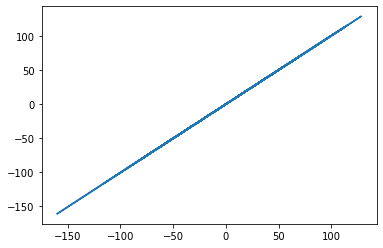

In [8]:
# verifyong the differential is computed correctly
plt.plot(X_dot[:, 0], [sigma*(X_t[i][1]-X_t[i][0]) for i in range(len(X_t))], label='Ground truth')

#### Library Theta

In [9]:
# generates degree-dimensional volume which have n discrete points on each dimension
# algorithm traverse points which are on/below diagnol
degree=2
polynomial_set=[]
list_items = [[i] for i in range(X_t.shape[1])]
polynomial_set.append(list_items)

for i in range(1,degree):
    polynomial_degree_i_set=[]
    next_branches_set=deepcopy(polynomial_set[i-1])
    for j in range(len(next_branches_set)):
        new_set_for_branch_j=[]
        for k in range(degree+1):
            if k > next_branches_set[j][len(next_branches_set[j])-1]:
                break
            new_instance=deepcopy(next_branches_set[j])
            new_instance.append(k)
            new_set_for_branch_j.append(new_instance)

        for set in new_set_for_branch_j:
            polynomial_degree_i_set.append(set)
    
    
    polynomial_set.append(polynomial_degree_i_set)


In [10]:
dict_index_To_colName={0:'x',1:'y',2:'z'}
theta_library_list=[]

for i in range(len(X_t)):
    temp_row = list(deepcopy(X_t[i]))
    for deg in polynomial_set[1:]:
        for comb in deg:
            value=1
            for index_col in comb:
                value*=X_t[i][index_col]
            temp_row.append(value)
    theta_library_list.append(temp_row)


if len(dict_index_To_colName) == len(X_t[0]):
    column_name_list=[]
    for deg in polynomial_set:
        for comb in deg:
            col_name=""
            for index_col in comb:
                col_name+=dict_index_To_colName[index_col]
            column_name_list.append(col_name)
    Theta_df = pd.DataFrame(theta_library_list, columns=column_name_list)
else:
    Theta_df = pd.DataFrame(theta_library_list)

Theta_df[:4]

,x,y,z,xx,yx,yy,zx,zy,zz
0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
1,1.012566,1.259920,0.984891,1.025289,1.275752,1.587398,0.997267,1.240884,0.970010
2,1.048821,1.524001,0.973114,1.100026,1.598405,2.322579,1.020623,1.483027,0.946952
3,1.107206,1.798315,0.965159,1.225906,1.991105,3.233935,1.068630,1.735660,0.931532


#### STLSQ

In [11]:
threshold = 0.1
max_iterations=100

df_library_theta_02 = deepcopy(Theta_df)
sol={}
for col in range(X_t.shape[1]):
    print("Column:", (col))
    theta_lib = deepcopy(df_library_theta_02)        
    # selected_cols = 
    total_sel_cols = len(theta_lib.columns)
    for itration in range(max_iterations):
        reg = LinearRegression().fit(theta_lib.values.tolist(), X_dot[:, col])
        selected_cols = [\
            [index,val, theta_lib.columns[index]]\
                for index,val in enumerate(reg.coef_)\
                    if abs(val) > threshold]

        if len(selected_cols) == total_sel_cols: # means no more filteration was done
            break
        print("iteration:",itration,"\tColumns Filtered:", total_sel_cols-len(selected_cols))
        total_sel_cols=len(selected_cols)

        # filter df using selected columns
        theta_lib = theta_lib.loc()[:,[x[2] for x in selected_cols]]
    if len(dict_index_To_colName) == len(X_t[0]):
        sol[dict_index_To_colName[col]] = selected_cols
    else:
        sol[col] = selected_cols

# sol["coef"]=reg.coef_      

Column: 0
iteration: 0 	Columns Filtered: 7
Column: 1
iteration: 0 	Columns Filtered: 6
Column: 2
iteration: 0 	Columns Filtered: 7


In [12]:
solution_detail={}
for ind in (dict_index_To_colName):
    col_nm=dict_index_To_colName[ind]
    intitial_str= str("d"+dict_index_To_colName[ind]+'/dt = ')
    for xx in sol[col_nm]:
        intitial_str += '('+str(round(xx[1],3))+')'+"*"+xx[2] + '+'
    print(intitial_str[:-1])


dx/dt = (-9.977)*x+(9.977)*y
dy/dt = (27.806)*x+(-0.962)*y+(-0.995)*zx
dz/dt = (-2.659)*z+(0.997)*yx


In [1]:

stt = [1.0, 1.0, 1.0]
def f_simulate(state_given, t):
    x, y, z = state_given
    dxdt= -9.977346169525438*x + 9.977341130132436*y
    dydt= 27.806074354426052*x - 0.9622144034553195*y - 0.9945059411818475*x*z
    dxdt=-2.6589719813925243*z + 0.9970028879194424*y*x
    return dxdt, dydt, dxdt

time_steps_Simulation = np.arange(0, 40, 0.01)

X_t_computed = odeint(f_simulate, state0, time_steps)

NameError: name 'np' is not defined

In [55]:
for colm in sol:
    print(sol[colm])

[[0, -9.977346169525438, 'x'], [1, 9.977341130132436, 'y']]
[[0, 27.806074354426052, 'x'], [1, -0.9622144034553195, 'y'], [2, -0.9945059411818475, 'zx']]
[[0, -2.6589719813925243, 'z'], [1, 0.9970028879194424, 'yx']]


In [13]:
# computing X_dot
map(f,time_steps)


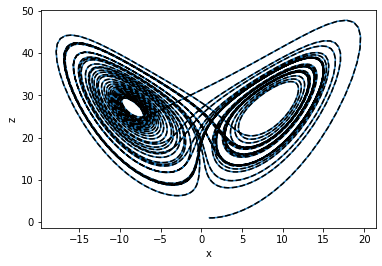

In [75]:
plt.plot(X_t[:, 0], X_t[:, 2], label='Ground truth')
plt.xlabel('x')
plt.ylabel('z')
plt.plot(X_t_computed[:, 0], X_t_computed[:, 2], 'k--',label='model')
# plt.xlabel('x')
# plt.ylabel('z')


[Text(0.5, 0, 't'), Text(0, 0.5, 'z')]

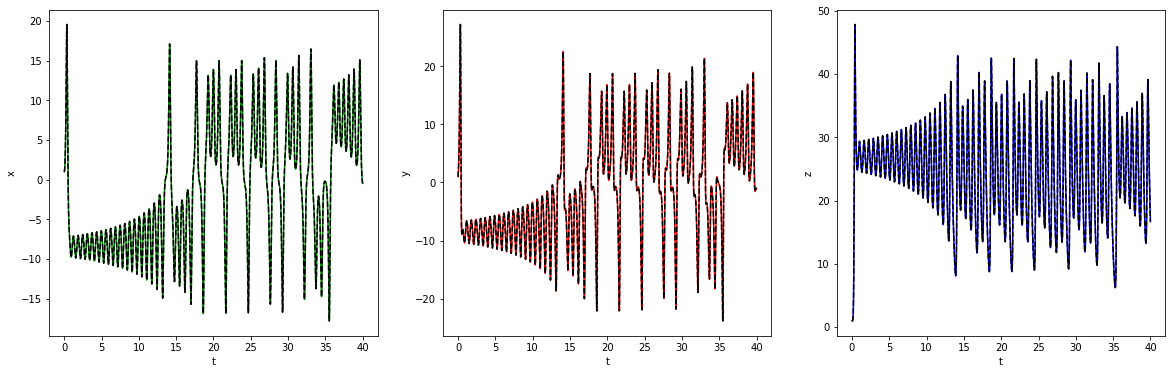

In [74]:
fig, axs = plt.subplots(1, 3, figsize=(20, 6))
axs[0].plot(time_steps, X_t[:, 0], 'g')
axs[0].plot(time_steps_Simulation, X_t_computed[:, 0], 'k--', label="model")
axs[0].set(xlabel="t", ylabel="x")

axs[1].plot(time_steps, X_t[:, 1], 'r')
axs[1].plot(time_steps_Simulation, X_t_computed[:, 1], 'k--', label="model")
axs[1].set(xlabel="t", ylabel="y")

axs[2].plot(time_steps, X_t[:, 2], 'b')
axs[2].plot(time_steps_Simulation, X_t_computed[:, 2], 'k--', label="model")
axs[2].set(xlabel="t", ylabel="z")
